<a href="https://colab.research.google.com/github/natalia0911/Tarea_Practica_4_IA/blob/main/2022_1_Trabajo_Practico_04_NataliaVargas_FabricioElizondo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Curso: Inteligencia Artificial**

**Primer Semestre 2022**

**Profesor: Luis-Alexander Calvo-Valverde**

**Trabajo Práctico:** 04

**Datos de la entrega:** Martes 14 de junio 2022, a más tardar a las 11:59 pm

**Estudiantes:**
- Natalia Vanessa Vargas Reyes
- Fabricio Antonio Elizondo Fernández


# Experimentación con regresión en redes neuronales artificiales

Indicaciones generales que deben seguir:
1. Se le proporcionan el conjunto de datos y un archivo de texto con una breve explicación de las columnas (esta es la versión del dataset que debe usar, no busque similares en internet).
1. Realizarán regresión y el atributo a predecir es: **price**.
1. Para que vayan experimentando lo que se vive en esta disciplina, Ustedes deben ir tomando las decisiones en el proceso y documentarlas en celdas de texto y además su código debe venir ampliamente comentado. Recuerden que el profesor hace de cliente por si tienen dudas. 
1. Deben dividir el dataset en tres conjuntos de datos: train (60%), validation (20%) y test (20%).
1. La red propuesta debe tener al menos dos capas ocultas.
1. Ustedes proponen el diseño experimental (quiero ver qué han entendido de este concepto fundamental en data science).
1. Deben utilizar **una de estas dos herramientas** para dar seguimiento a los resultados en el caso de la red neuronal artificial: 
    1. https://www.wandb.com/
    1. https://www.comet.ml/site/


Criterios de evaluación:
1. Deben presentar una implementación completa, en una de estas opciones: pytorch, tensorflow o keras (Claro que pueden usar numpy, pandas y otras bibliotecas más, para todo el tema de carga del dataset, analizarlo y pre-procesarlo). (**55 puntos**)
1. Uso de herramienta de seguimiento de resultados. (**10 puntos**)
1. Documentación de decisiones en celdas de texto y comentarios al código. (**20 puntos**)
1. Conclusiones finales: En una celda de código al final del cuaderno, incluya sus conclusiones más importantes del experimento y algunos de los gráficos que genera la herramienta seleccionada, junto con su interpretación de los mismos. (**15 puntos**)

##1. Preprocesamiento

In [1]:
%matplotlib inline
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
diamonds_df = pd.read_csv('/content/drive/MyDrive/1 SEMESTRE 2022/IA/Trabajo Práctico 4/diamonds.csv', header = 0, delimiter=',')  
#print(dataset.describe())
print(diamonds_df.head(5))
#Ver las filas
print(diamonds_df.shape[0])

   id  carat      cut color clarity  depth  table  price     x     y     z
0   1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
53940


In [4]:
# Se realiza una comprobación del tipo de dato de cada columna
print(diamonds_df.dtypes)

id           int64
carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object


####Histogramas
A continuación se muestran histogramas de los atributos. Esto nos permitirá ver las distribuciones de los mismos, y determinar cuales son ordinales o categoricos, de manera que más adelante se puedan tomar las medidas del caso codificando esos determinados atributos.

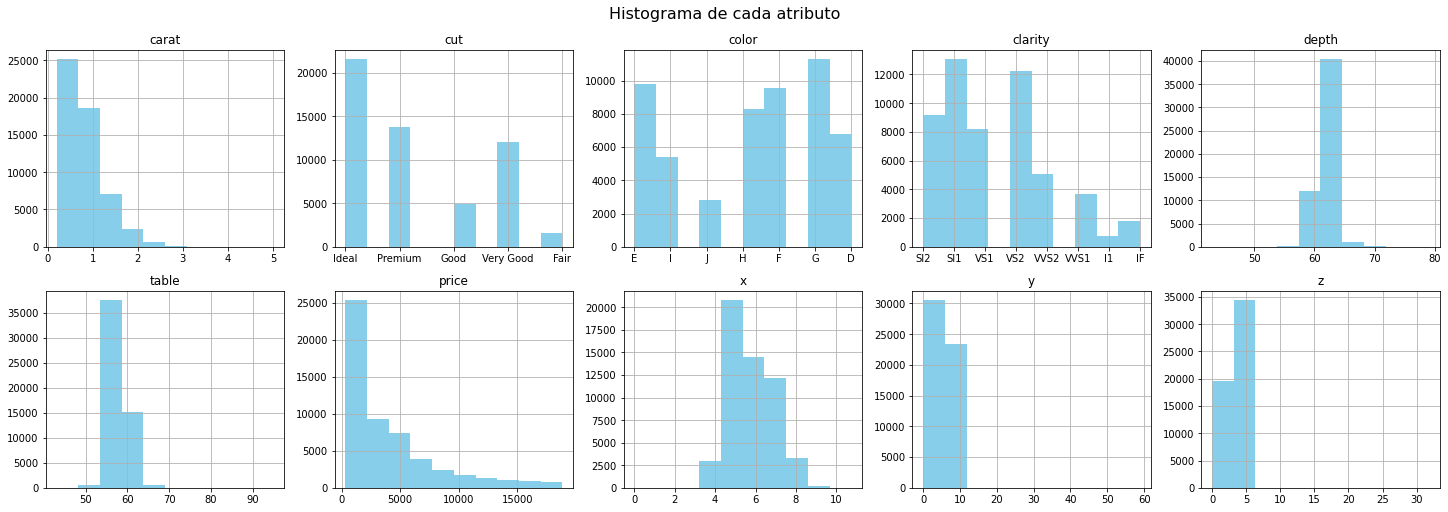

In [5]:
# Se grafican cada uno de los atributos utilizando un histrograma
fig, axs = plt.subplots(2, 5, constrained_layout=True, figsize=(20,7))
fig.suptitle('Histograma de cada atributo', fontsize=16)

d = 1
for i in range(2):
  for j in range(5):
    axs[i,j].set_title(diamonds_df.columns[d])
    diamonds_df.iloc[:, d].hist(ax=axs[i,j], color='skyblue')
    d += 1

plt.show()

Como podemos observar en la gráficas, tenemos una variables que puedan ser ordinaria, que es el caso de cut y tenemos 2 que son binarias, en este caso son color y clarity. Estas se deberán codificar para tratarlas como números. 

####Verificar outliers
Con diagramas de cajas podemos verificar visualmente si se encuentran valores que son outliers, es decir que se alejen de la media. 
En este caso solo mostramos los valores que no de tipo Object. 

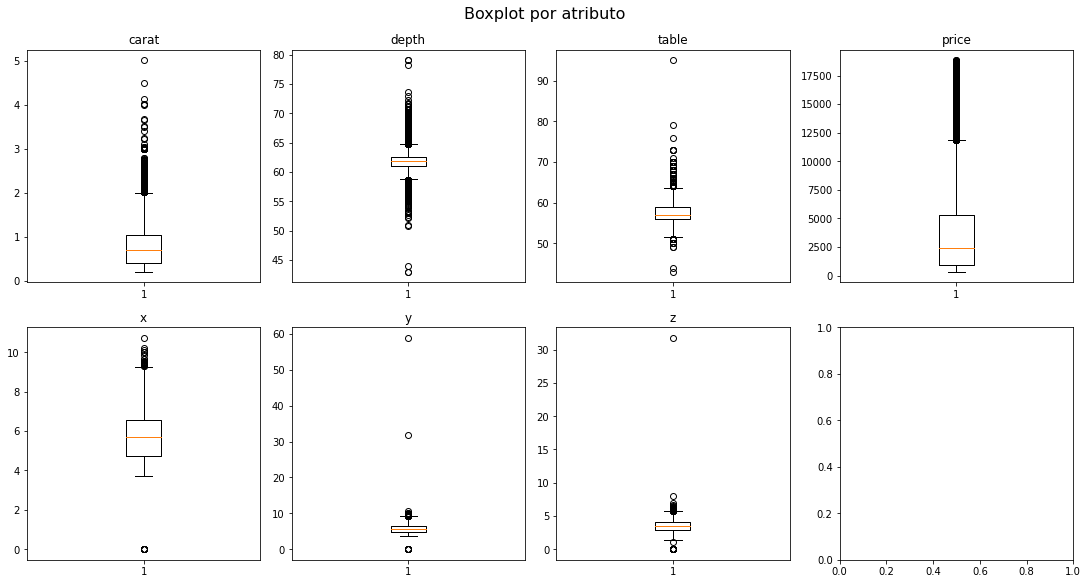

In [47]:
# Se grafica con un boxplot cada uno de los atributos del dataset
fig, axs = plt.subplots(2, 4, constrained_layout=True, figsize=(15,8))
fig.suptitle('Boxplot por atributo', fontsize=16)

invalid = [1,5,6,7,8,9,10] #10
index = 0
for i in range(2):
  for j in range(4):
    if not((i,j)==(1,3)):
      axs[i,j].set_title(diamonds_df.columns[invalid[index]])
      axs[i,j].boxplot(diamonds_df.iloc[:,invalid[index]])
    index+=1
    


####Verificar valores faltantes
Hacemos un conteo de las filas que hay en el dataset y también de los filas para cada atributo, con la función count, que me devuelve solamente la cantidad de celdas no vacías.

In [6]:
print("Cantidad de muestras ",len(diamonds_df), "\n")
print(diamonds_df.count())

Cantidad de muestras  53940 

id         53940
carat      53940
cut        53940
color      53940
clarity    53940
depth      53940
table      53940
price      53940
x          53940
y          53940
z          53940
dtype: int64


####Análisis de los outliers
Se crea una función que nos permite comprobar cuáles son los outliers para una determinado atributo 

In [7]:
def printOutliers(data):
  print("---------------- Resumen Estadístico de la variable ----------------")
  print(data.describe())

  values = data.iloc[:, 0]
  print("------------------------- Ver outliers -----------------------------")
  #Imprimir valores que se encuentren entre dichos cuartiles
  print(values[values.between(values.quantile(0), values.quantile(.003))] )
  print("-----------------------------------------------")
  print(values[values.between(values.quantile(.997), values.quantile(1))] )

In [6]:
data = pd.DataFrame(diamonds_df.carat)
printOutliers(data)

---------------- Resumen Estadístico de la variable ----------------
              carat
count  53940.000000
mean       0.797940
std        0.474011
min        0.200000
25%        0.400000
50%        0.700000
75%        1.040000
max        5.010000
------------------------- Ver outliers -----------------------------
0        0.23
1        0.21
2        0.23
8        0.22
9        0.23
         ... 
52302    0.23
52303    0.23
52304    0.23
52310    0.23
52314    0.23
Name: carat, Length: 319, dtype: float64
-----------------------------------------------
15684    2.49
16283    3.00
17196    2.72
19081    2.50
19339    3.01
         ... 
27684    3.01
27685    3.01
27727    2.61
27731    2.55
27739    2.80
Name: carat, Length: 165, dtype: float64


In [7]:
data = pd.DataFrame(diamonds_df.depth)
printOutliers(data)

---------------- Resumen Estadístico de la variable ----------------
              depth
count  53940.000000
mean      61.749405
std        1.432621
min       43.000000
25%       61.000000
50%       61.800000
75%       62.500000
max       79.000000
------------------------- Ver outliers -----------------------------
91       55.1
227      55.1
423      55.0
440      56.0
443      53.1
         ... 
52474    55.5
53064    56.5
53542    54.7
53756    55.6
53757    55.4
Name: depth, Length: 166, dtype: float64
-----------------------------------------------
204      67.9
298      67.4
352      67.3
385      68.1
714      67.8
         ... 
52861    79.0
52993    67.7
53434    67.6
53540    72.9
53800    68.7
Name: depth, Length: 169, dtype: float64


In [8]:
data = pd.DataFrame(diamonds_df.table)
printOutliers(data)

---------------- Resumen Estadístico de la variable ----------------
              table
count  53940.000000
mean      57.457184
std        2.234491
min       43.000000
25%       56.000000
50%       57.000000
75%       59.000000
max       95.000000
------------------------- Ver outliers -----------------------------
115      53.0
243      52.0
593      53.0
612      53.0
630      53.0
         ... 
53657    53.0
53688    52.0
53706    53.0
53771    53.0
53881    53.0
Name: table, Length: 643, dtype: float64
-----------------------------------------------
91       69.0
227      67.0
296      66.0
314      70.0
356      66.0
         ... 
52865    66.0
53064    68.0
53154    66.0
53542    67.0
53660    67.0
Name: table, Length: 180, dtype: float64


In [9]:
data = pd.DataFrame(diamonds_df.price)
printOutliers(data)

---------------- Resumen Estadístico de la variable ----------------
              price
count  53940.000000
mean    3932.799722
std     3989.439738
min      326.000000
25%      950.000000
50%     2401.000000
75%     5324.250000
max    18823.000000
------------------------- Ver outliers -----------------------------
0        326
1        326
2        327
3        334
4        335
        ... 
41595    391
41596    391
41597    391
41598    391
41599    391
Name: price, Length: 170, dtype: int64
-----------------------------------------------
27558    18359
27559    18363
27560    18364
27561    18369
27562    18371
         ...  
27745    18803
27746    18804
27747    18806
27748    18818
27749    18823
Name: price, Length: 162, dtype: int64


In [10]:
data = pd.DataFrame(diamonds_df.x)
printOutliers(data)

---------------- Resumen Estadístico de la variable ----------------
                  x
count  53940.000000
mean       5.731157
std        1.121761
min        0.000000
25%        4.710000
50%        5.700000
75%        6.540000
max       10.740000
------------------------- Ver outliers -----------------------------
1        3.89
8        3.87
11       3.93
12       3.88
14       3.79
         ... 
50639    3.90
52643    3.92
52957    3.93
52960    3.92
52967    3.93
Name: x, Length: 186, dtype: float64
-----------------------------------------------
16283    9.23
17097    8.75
17897    8.71
19339    9.10
19346    8.93
         ... 
27685    9.41
27726    8.69
27727    8.85
27731    8.70
27739    8.90
Name: x, Length: 166, dtype: float64


In [11]:
data = pd.DataFrame(diamonds_df.y)
printOutliers(data)

---------------- Resumen Estadístico de la variable ----------------
                  y
count  53940.000000
mean       5.734526
std        1.142135
min        0.000000
25%        4.720000
50%        5.710000
75%        6.540000
max       58.900000
------------------------- Ver outliers -----------------------------
1        3.84
5        3.96
8        3.78
11       3.90
12       3.84
         ... 
50634    3.89
52302    3.96
52310    3.95
52960    3.93
52967    3.96
Name: y, Length: 200, dtype: float64
-----------------------------------------------
16283     9.10
17097     8.69
19339     8.97
19346     8.84
19866     9.07
         ...  
27726     8.75
27727     8.73
27731     8.65
27739     8.85
49189    31.80
Name: y, Length: 166, dtype: float64


In [12]:
data = pd.DataFrame(diamonds_df.z)
printOutliers(data)

---------------- Resumen Estadístico de la variable ----------------
                  z
count  53940.000000
mean       3.538734
std        0.705699
min        0.000000
25%        2.910000
50%        3.530000
75%        4.040000
max       31.800000
------------------------- Ver outliers -----------------------------
1        2.31
2        2.31
9        2.39
12       2.33
14       2.27
         ... 
52953    2.40
52954    2.41
52955    2.40
52956    2.39
52975    2.40
Name: z, Length: 192, dtype: float64
-----------------------------------------------
13002     5.36
13757     5.36
14138     5.43
15684     5.45
16283     5.77
         ...  
27684     5.64
27685     5.59
27727     5.46
27731     5.36
48410    31.80
Name: z, Length: 169, dtype: float64


####Separar en Train 60%, Test 20% y Validation 20%

In [4]:
#Separar los datos en X y Y, donde Y es la variable que queremos predecir
my_data = diamonds_df.copy()
x = my_data.drop(['price'], axis=1)
cantidad_muestras = len(my_data)
y = pd.DataFrame(my_data, columns = ['price'])

print("\nMuestra fila 1 de X: \n", x[0:1])
print("\nMuestra fila 1 de Y: \n", y[0:1])
print("\nCantidad de muestras: ", len(my_data))
print("\nCantidad de atributos (incluye y): ", my_data.shape[1])
print(len(x), len(y))


Muestra fila 1 de X: 
    id  carat    cut color clarity  depth  table     x     y     z
0   1   0.23  Ideal     E     SI2   61.5   55.0  3.95  3.98  2.43

Muestra fila 1 de Y: 
    price
0    326

Cantidad de muestras:  53940

Cantidad de atributos (incluye y):  11
53940 53940


In [70]:
from sklearn.model_selection import train_test_split
#Se divide el conjunto de datos en Train, Validation y Test
X_train, X_test, Y_train, Y_test = train_test_split(x, 
                                                    y, 
                                                    train_size=0.6,
                                                    shuffle=True,     #Mezclar los datos y que se reparta aleatoriamente
                                                    random_state=40)  #Definir una semilla para usar los mismos valores en todas las corridas

X_val, X_test, Y_val, Y_test  = train_test_split(   X_test, 
                                                    Y_test, 
                                                    test_size=0.5,
                                                    shuffle=True,     #Mezclar los datos y que se reparta aleatoriamente
                                                    random_state=40)  #Definir una semilla para usar los mismos valores en todas las corridas

print("\nTamaño de X_train + X_val  + X_test : ", len(X_train)+len(X_val)+len(X_test))
print("\nTamaño del train: ", len(X_train))
print("\nTamaño del test: ", len(X_test))
print("\nTamaño del validation: ", len(X_val))
print("\nPrimer elemento del X_train:")
print( X_train[0:1])
print("\nPrimer elemento del X_test:")
print( X_test[0:1])
print("\nPrimer elemento del X_val:")
print( X_val[0:1])
print("\nPrimer elemento del y_train:")
print( Y_train[0:1])
print("\nPrimer elemento del y_test:")
print( Y_test[0:1])
print("\nPrimer elemento del y_val:")
print( Y_val[0:1])


Tamaño de X_train + X_val  + X_test :  53940

Tamaño del train:  32364

Tamaño del test:  10788

Tamaño del validation:  10788

Primer elemento del X_train:
          id  carat        cut color clarity  depth  table     x     y     z
31225  31226   0.32  Very Good     D     SI1   63.5   55.0  4.35  4.31  2.75

Primer elemento del X_test:
          id  carat      cut color clarity  depth  table     x     y     z
14402  14403   1.06  Premium     D     SI1   59.4   57.0  6.72  6.65  3.97

Primer elemento del X_val:
          id  carat    cut color clarity  depth  table     x     y     z
16646  16647   1.22  Ideal     H     SI1   61.8   57.0  6.83  6.85  4.23

Primer elemento del y_train:
       price
31225    756

Primer elemento del y_test:
       price
14402   5817

Primer elemento del y_val:
       price
16646   6654


####Se elimina la columna Id

In [ ]:
X_train = X_train.drop('id', 1)
X_val = X_val.drop('id', 1)
X_test = X_test.drop('id', 1)

# Se almacena en una variable los valores de las nuevas columnas del arreglo X
column_names = X_train.columns.values

####Codificar atributos ordinales

In [72]:
#Se crea un diccionario con los valores correspondientes para los valores de las variables ordinales
mapping_cut = { "Ideal" :5,"Premium" :4,"Very Good":3, "Good" :2, "Fair":1 }   
mapping_clarity = {"I1":1, "SI2":2, "SI1":3, "VS2":4, "VS1":5, "VVS2":6, "VVS1":7, "IF":8}
mapping_color = {"D":7,"E":6,"F":5,"G":4,"H":3,"I":2,"J":1}

# Se hace el reemplazo en el test, train y val
X_test = X_test.replace(mapping_cut).replace(mapping_clarity).replace(mapping_color)
X_train = X_train.replace(mapping_cut).replace(mapping_clarity).replace(mapping_color)
X_val = X_val.replace(mapping_cut).replace(mapping_clarity).replace(mapping_color)
#Se imprimen los primeros 5 de cada conjunto
print(X_train.head(5))
print("------------------------------------------------------------------------")
print(X_test.head(5))
print("------------------------------------------------------------------------")
print(X_val.head(5))

       carat  cut  color  clarity  depth  table     x     y     z
31225   0.32    3      7        3   63.5   55.0  4.35  4.31  2.75
30184   0.31    5      6        5   61.2   55.0  4.40  4.43  2.70
28941   0.30    5      4        6   62.7   57.0  4.26  4.29  2.68
40571   0.40    5      7        6   61.4   56.0  4.80  4.75  2.93
4819    0.91    3      2        3   62.8   57.0  6.09  6.18  3.85
------------------------------------------------------------------------
       carat  cut  color  clarity  depth  table     x     y     z
14402   1.06    4      7        3   59.4   57.0  6.72  6.65  3.97
29551   0.25    5      6        6   61.7   56.0  4.05  4.07  2.50
47807   0.57    3      5        6   63.2   56.0  5.28  5.32  3.35
31088   0.33    3      4        6   60.0   63.0  4.45  4.49  2.68
5726    0.27    3      7        6   64.6   53.0  4.04  4.10  2.63
------------------------------------------------------------------------
       carat  cut  color  clarity  depth  table     x     y   

####Escalar datos

In [73]:
from sklearn.preprocessing import RobustScaler
# Escalar datos
transformer = RobustScaler().fit(X_train)
#Se deben escalar tanto train como test
X_train = transformer.transform( X_train)
X_test = transformer.transform( X_test)
X_val = transformer.transform( X_val)
print("Primeros X_train: ", X_train[0:2])
print("Primeros X_test: ", X_test[0:2])
print("Primeros X_val: ", X_val[0:2])

Primeros X_train:  [[-0.59375    -0.5         1.         -0.5         1.21428571 -0.66666667
  -0.74175824 -0.77348066 -0.69026549]
 [-0.609375    0.5         0.66666667  0.5        -0.42857143 -0.66666667
  -0.71428571 -0.70718232 -0.73451327]]
Primeros X_test:  [[ 0.5625      0.          1.         -0.5        -1.71428571  0.
   0.56043956  0.51933702  0.38938053]
 [-0.703125    0.5         0.66666667  1.         -0.07142857 -0.33333333
  -0.90659341 -0.90607735 -0.91150442]]
Primeros X_val:  [[ 0.8125      0.5        -0.33333333 -0.5         0.          0.
   0.62087912  0.62983425  0.61946903]
 [-0.609375    0.          0.          2.         -0.57142857  0.66666667
  -0.75274725 -0.74585635 -0.77876106]]


####Guardar en un archivo el dataset preprocesado

In [74]:
from pathlib import Path

#JUNTAR XTRAIN,YTRAIN, XTEST,YTEST XVAL,YVAL
new_columns_names = np.append(column_names,'price')
print(new_columns_names)

X_concat = np.concatenate((X_train, X_val, X_test), axis=0)

Y_concat = np.concatenate((Y_train,Y_val,Y_test), axis=0)
#Se convierte a matriz 
Y_concat = np.asmatrix(Y_concat)
#Se agrega la columna de Y traspuestA
data = np.concatenate((X_concat,Y_concat), axis=1)

#Guardar el dataset en un csv
X_df = pd.DataFrame(data = data, columns = new_columns_names)
X_df.to_csv("diamonds_preprocessed.csv",index=False,sep= ";")

['carat' 'cut' 'color' 'clarity' 'depth' 'table' 'x' 'y' 'z' 'price']


In [76]:
X_train = pd.DataFrame(data= X_train, columns= column_names)
X_test = pd.DataFrame(data= X_test, columns= column_names)
X_val = pd.DataFrame(data= X_val, columns= column_names)
Y_train = pd.DataFrame(data= Y_train, columns= ['price'])
Y_test = pd.DataFrame(data= Y_test, columns= ['price'])
Y_val = pd.DataFrame(data= Y_val, columns= ['price'])

##2. Red neuronal 

In [77]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[9]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='softmax')
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001) #ver que onda con learning rate 

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [78]:
model = build_model()

In [79]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                640       
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = model.fit(
                    X_train,
                    Y_train, 
                    epochs=10, 
                    validation_data=(X_val, Y_val))

Epoch 1/10
1012/1012 [==============================] - 4s 4ms/step - loss: 31385670.0000 - mae: 3936.5510 - mse: 31385670.0000 - val_loss: 31754992.0000 - val_mae: 3941.3215 - val_mse: 31754992.0000
Epoch 2/10
1012/1012 [==============================] - 3s 3ms/step - loss: 31385656.0000 - mae: 3936.5505 - mse: 31385656.0000 - val_loss: 31754992.0000 - val_mae: 3941.3215 - val_mse: 31754992.0000
Epoch 3/10
1012/1012 [==============================] - 4s 3ms/step - loss: 31385650.0000 - mae: 3936.5544 - mse: 31385650.0000 - val_loss: 31754992.0000 - val_mae: 3941.3215 - val_mse: 31754992.0000
Epoch 4/10
1012/1012 [==============================] - 4s 4ms/step - loss: 31385678.0000 - mae: 3936.5518 - mse: 31385678.0000 - val_loss: 31754992.0000 - val_mae: 3941.3215 - val_mse: 31754992.0000
Epoch 5/10
1012/1012 [==============================] - 4s 4ms/step - loss: 31385674.0000 - mae: 3936.5532 - mse: 31385674.0000 - val_loss: 31754992.0000 - val_mae: 3941.3215 - val_mse: 31754992.0000


In [87]:
history.history

{'loss': [31385670.0,
  31385656.0,
  31385650.0,
  31385678.0,
  31385674.0,
  31385624.0,
  31385650.0,
  31385662.0,
  31385648.0,
  31385640.0],
 'mae': [3936.551025390625,
  3936.550537109375,
  3936.554443359375,
  3936.5517578125,
  3936.55322265625,
  3936.5537109375,
  3936.555419921875,
  3936.553466796875,
  3936.552734375,
  3936.552978515625],
 'mse': [31385670.0,
  31385656.0,
  31385650.0,
  31385678.0,
  31385674.0,
  31385624.0,
  31385650.0,
  31385662.0,
  31385648.0,
  31385640.0],
 'val_loss': [31754992.0,
  31754992.0,
  31754992.0,
  31754992.0,
  31754992.0,
  31754992.0,
  31754992.0,
  31754992.0,
  31754992.0,
  31754992.0],
 'val_mae': [3941.321533203125,
  3941.321533203125,
  3941.321533203125,
  3941.321533203125,
  3941.321533203125,
  3941.321533203125,
  3941.321533203125,
  3941.321533203125,
  3941.321533203125,
  3941.321533203125],
 'val_mse': [31754992.0,
  31754992.0,
  31754992.0,
  31754992.0,
  31754992.0,
  31754992.0,
  31754992.0,
  3175499

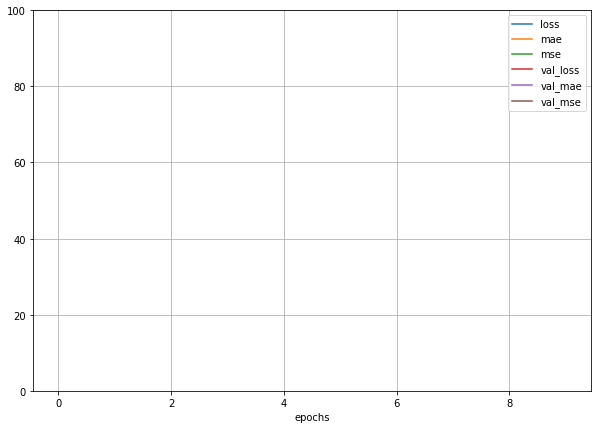

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 100)
plt.xlabel("epochs")
plt.show()